# Data Cleaning 

Analysing the dataset's information we can see that the shared data are the trip duration (although this figure is not always given explicitly but can be calculated by having the time of departure and arrival), the starting and ending station (name or ID), the user type and the bike ID.

These data are not present in all datasets: duration is not present in the newer version of CityBike NYC, in CoGo's trips data and in Divvy's data, start and end times are not present in the Austin MetroBike (it is only present the end time and the duration so we can infer that), start and end stations are not present in the Austin MetroBike and the bike id is not present in Divvy's dataset.
It therefore seems impossible to have data shared by all datasets but those reported to you may be the most important ones to work on.

Another information that is present in some of the dataset are the year of Birth, the gender and the station latitude and longitude. The first two data can be useful for a social analysis on the age and the gender of the user in different cities but this data are only presented in the older version of the CityBike NYC, in BluBike and in CoGo's dataset.

Starting year of each dataset:
- CityBike NYC, 2013
- BlueBike Boston, 2015
- Capital BikeShare Washington, 2010
- Bay Wheels San Francisco, 2017
- CoGo Columbus, 2018
- Austin MetroBike, 2014 (mixed)
- Divvy Chicago, (2014, incomplete) 2020
- IndeGo Philly, 2015 (incomplete)

## Get the duration information
The function get_duration_info() takes a DataFrame, analyzes the data internally and clusters them into five different classes: '< 500', '< 1000', '< 10000', '< 100000' and '> 100000'.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import os

def get_duration_info(df, number, axs):
    df = df.sort_values(by='tripduration')
    durations = df['tripduration']

    # Define a function to determine the cluster for each number
    def get_cluster(num):
        if num < 500:
            return "< 500"
        elif num < 1000:
            return "< 1000"
        elif num < 10000:
            return "< 10000"
        elif num < 100000:
            return "< 100000"
        else:
            return "> 100000"

    # Group numbers into clusters
    clusters = [get_cluster(num) for num in durations]

    # Calculate frequency of each cluster
    frequency = Counter(clusters)

    # Extract cluster names and their frequencies
    cluster_names = list(frequency.keys())
    cluster_frequencies = list(frequency.values())
    total = sum(cluster_frequencies)
    for value in range(len(cluster_frequencies)):
        cluster_frequencies[value] /= total
    
    x = number // 3
    y = number % 3
    axs[x, y].bar(cluster_names, cluster_frequencies)
    for index in range(len(cluster_names)):
        axs[x, y].text(index, cluster_frequencies[index], str(round(cluster_frequencies[index], 5)), ha='center')

    # Add labels and title
    for ax in axs.flat:
        ax.set(xlabel='Trip duration', ylabel='Frequency')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()
    fig.suptitle('Frequency of Trip Duration')


## Data Integration
Data is divided into multiple file so we need to integrate in a single file the data of a single month in order to evaluate them together.

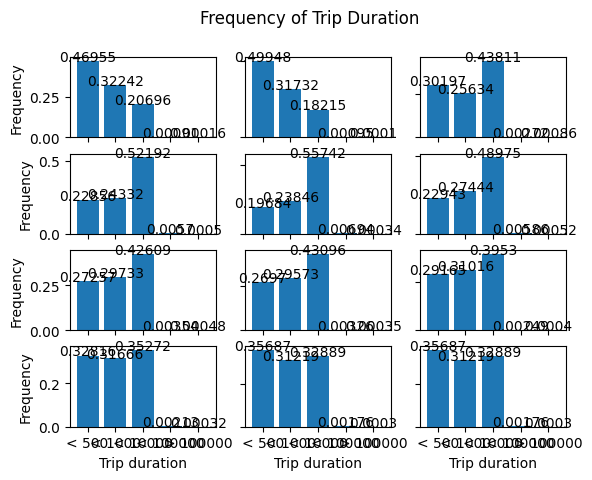

In [8]:
data_dir = 'D:/unitn/Bike-Inequality/data/NYC'

data_files = os.listdir(data_dir)

dfs = list()
previous_file = ""
month = 0

fig, ax = plt.subplots(4, 3)

for file in data_files:
    # read data from each file into a DataFrame
    file_path = os.path.join(data_dir, file)
    
    df = pd.read_csv(file_path)
    if file[0:6] != previous_file[0:6] and previous_file != "":
        if len(dfs) != 0:
            integrated_df = pd.concat(dfs, ignore_index=True)
            get_duration_info(integrated_df, month, ax)
            dfs.clear()
            month += 1
        else:
            get_duration_info(df, month, ax)
            month += 1
    else:
        dfs.append(df)
    
    previous_file = file
    
get_duration_info(integrated_df, month, ax)

# Show plot
plt.show()